# Regressio - eri mallien kokeilua

Lineaarisen regression ohella on tarjolla monia regressiomalleja, jotka sopivat myös ei-lineaaristen riippuvuuksien mallintamiseen.

Seuraavassa käytän kahta ensemble-mallia (ensemble-malli = yhdistelmä useista malleista):

* Satunnaismetsä-regressio (RandomForestRegressor); satunnaismetsä, soveltuu erityisesti ylimallintamisen välttämiseen
* Gradienttitehostus-regressio (GradientBoostingRegressor); antaa usein muita menetelmiä tarkempia ennusteita

In [1]:
from datetime import datetime
print(f'Päivitetty {datetime.now()}')

Päivitetty 2023-02-23 13:49:35.545872


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# train_test_split osaa jakaa datan opetusdataan ja testidataan
from sklearn.model_selection import train_test_split

# Käytettävät mallit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Seuraava komento kannattaa tässä antaa varmuuden vuoksi
# Ilman tätä joissain versioissa kuviot eivät tulostu näkyville
%matplotlib inline

## Funktio mallin sovittamiseen ja tarkasteluun

Jos samaa koodia käytetään toistuvasti, niin siitä kannattaa tehdä funktio.

In [3]:
def mallinna(malli):
    
    # Mallin sovitus opetusdataan
    malli.fit(X_train, y_train)
            
    # Selityskerroin opetusdatalle
    y_pred_train = malli.predict(X_train)
    R2_train_malli = malli.score(X_train, y_train)
        
    # Selityskerroin testidatalle
    y_pred_test = malli.predict(X_test)
    R2_test_malli = malli.score(X_test, y_test)
        
    # Selityskertoimien tulostus
    print(f'Opetusdatan selityskerroin {R2_train_malli:.3f}')
    print(f'Testidatan selityskerroin {R2_test_malli:.3f}')
       
    # Opetusdatan virhetermit kaaviona
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].set_title('Ennustevirheiden jakauma opetusdatassa')
    sns.histplot((y_train-y_pred_train), kde=True, ax=ax[0])
    ax[0].set_xlabel('y_train - y_pred_train')
    
    # toteutuneet ja ennustetut hajontakaaviona testidatalle
    ax[1].set_title('Toteutuneet ja ennustetut testidatassa')
    ax[1].scatter(x=y_test, y=y_pred_test)
    ax[1].set_xlabel('toteutunut')
    ax[1].set_ylabel('ennuste')

## Datan tarkastelua

In [4]:
df = pd.read_csv('https://taanila.fi/Advertising.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   TV          200 non-null    float64
 2   radio       200 non-null    float64
 3   newspaper   200 non-null    float64
 4   sales       200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB


In [5]:
df

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9
...,...,...,...,...,...
195,196,38.2,3.7,13.8,7.6
196,197,94.2,4.9,8.1,9.7
197,198,177.0,9.3,6.4,12.8
198,199,283.6,42.0,66.2,25.5


In [6]:
# Poistetaan tarpeeton järjestysnumero-sarake
df = df.drop('Unnamed: 0', axis = 1)
df

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,9.7
197,177.0,9.3,6.4,12.8
198,283.6,42.0,66.2,25.5


In [7]:
df.describe()

,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


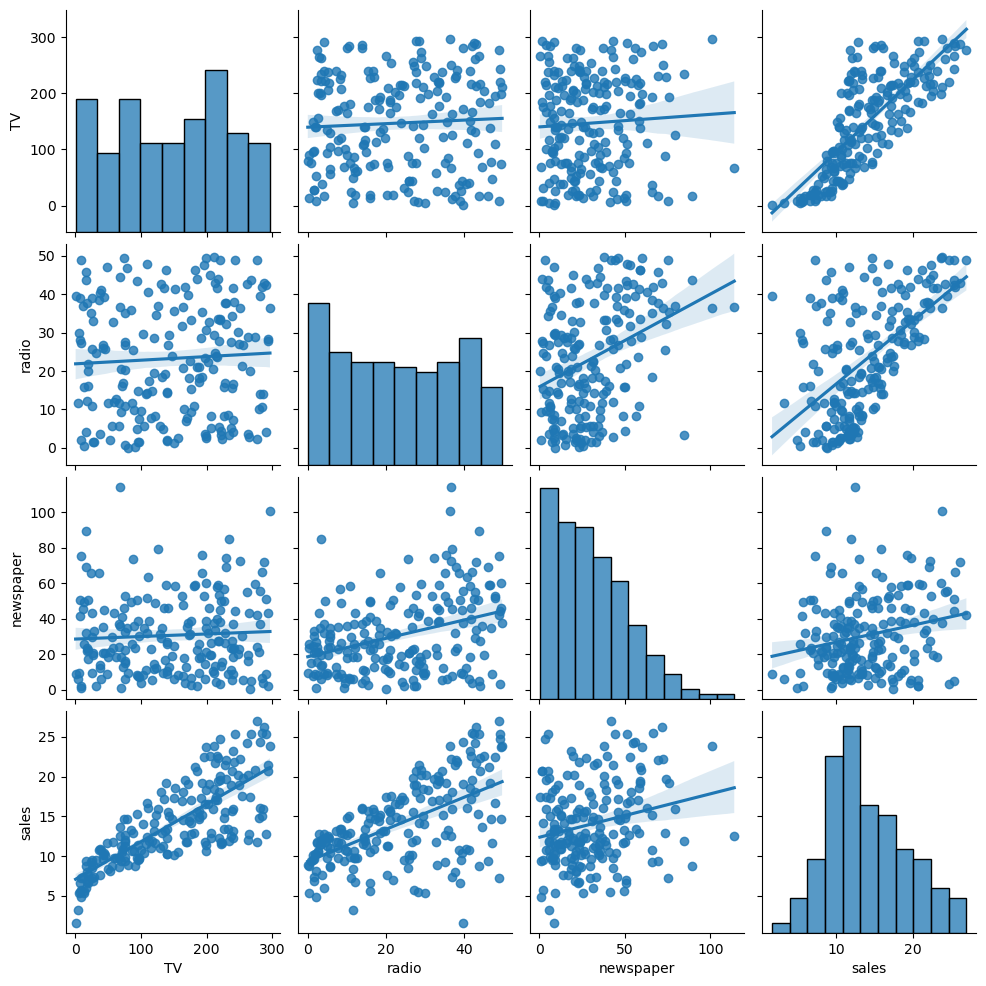

In [8]:
# Riippuvuuksien tarkastelua hajontakaavioina
sns.pairplot(df, kind = 'reg')

<AxesSubplot:>

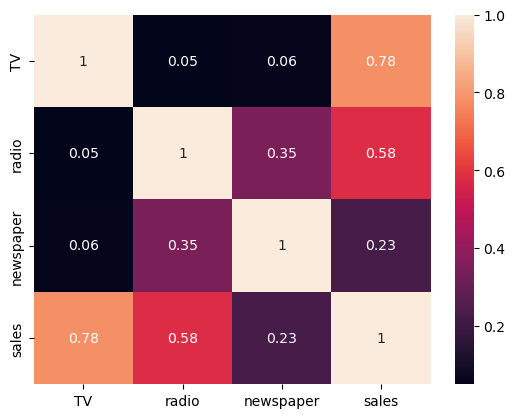

In [9]:
# Riippuvuuksien tarkastelua korrelaatiokertoimien avulla
correlation_matrix = df.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

## Mallien sovittaminen

In [10]:
# Selittävät muuttujat
X = df[['TV', 'radio', 'newspaper']]

# Kohdemuuttuja
y = df['sales'] 

In [11]:
# Jako opetus- ja testidataan
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

### Lineaarinen regressio

Opetusdatan selityskerroin 0.932
Testidatan selityskerroin 0.756


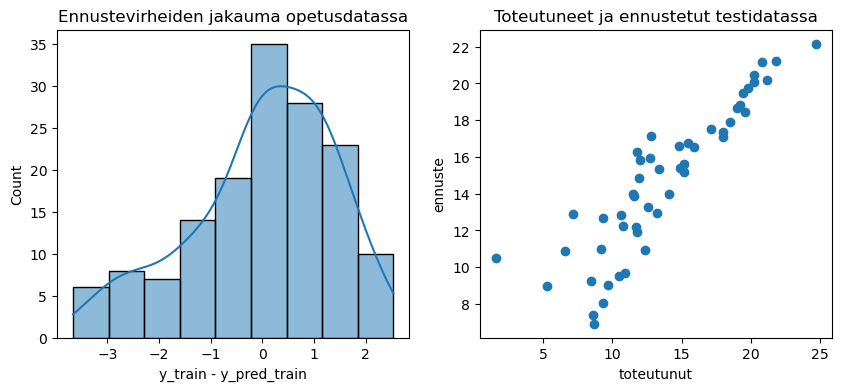

In [12]:
malli = LinearRegression()

# Tässä hyödynnän aiemmin määriteltyä mallinna-funktiota
mallinna(malli)

### Satunnaismetsä

Opetusdatan selityskerroin 0.998
Testidatan selityskerroin 0.966


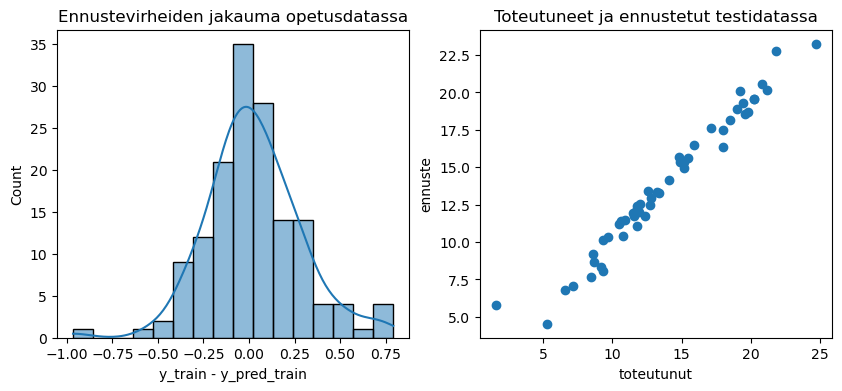

In [13]:
malli = RandomForestRegressor()
mallinna(malli)

### Gradienttitehostus

Opetusdatan selityskerroin 0.999
Testidatan selityskerroin 0.958


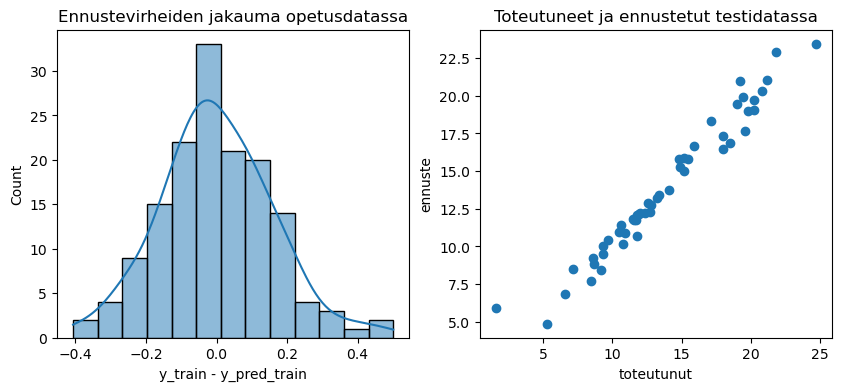

In [14]:
malli = GradientBoostingRegressor()
mallinna(malli)